In [ ]:
/home/j597s263/scratch/j597s263/Datasets/Explanation_values/Resnet/ShapImg.npy

In [1]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.amp import GradScaler, autocast
import os
import random
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ConvMixer input size
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.Imagenette(root='/home/j597s263/scratch/j597s263/Datasets/imagenette', download=False, transform=transform)

# Shuffle indices with a fixed random seed for reproducibility
random.seed(42)  # Use any fixed seed for consistency
indices = list(range(len(dataset)))
random.shuffle(indices)

# Split shuffled indices into training and testing
train_indices = indices[:7568]
test_indices = indices[7568:8522]
attack_indices = indices[8522:]

# Create Subsets
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)
attack_data = Subset(dataset, attack_indices)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Shuffle within batches
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)  # No shuffle for test set
attack_loader = DataLoader(attack_data, batch_size=5, shuffle=True)

# Print dataset sizes
print(f"Attack samples: {len(attack_data)}")
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

Attack samples: 947
Training samples: 7568
Test samples: 954


In [2]:
import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [3]:
import torch
# Load the entire model
model = torch.load('/home/j597s263/scratch/j597s263/Models/Resnet/ResImageBase.mod', weights_only=False, map_location="cuda")

# Move the model to the appropriate device
model = model.to('cuda')

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


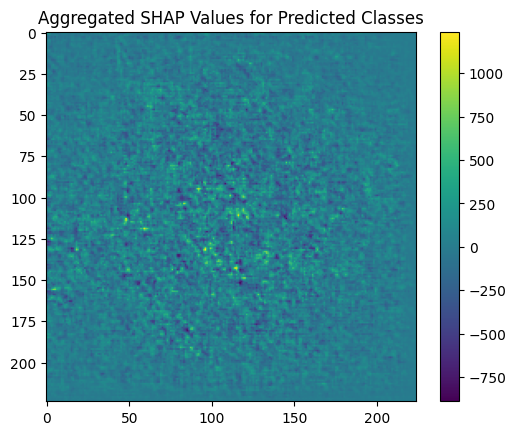

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load SHAP values
file_path = '/home/j597s263/scratch/j597s263/Datasets/Explanation_values/Resnet/ShapImg.npy'
shap_values = np.load(file_path)  # Shape: (3, 224, 224, 10)


device = 'cuda'
model.eval()

# Initialize aggregated SHAP array
aggregated_shap_image = np.zeros((224, 224))

# Iterate through the attack_loader to compute predicted classes
for batch_images, _ in attack_loader:
    batch_images = batch_images.to(device)

    # Get model predictions
    outputs = model(batch_images)
    predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy()  # Shape: (batch_size,)

    # Compute SHAP values for each image
    for i, predicted_class in enumerate(predicted_classes):
        # Aggregate SHAP values for the predicted class (sum over channels)
        class_shap_values = np.sum(shap_values[:, :, :, predicted_class], axis=0)  # Shape: (224, 224)
        aggregated_shap_image += class_shap_values

# Visualize the aggregated SHAP image
plt.imshow(aggregated_shap_image, cmap="viridis")
plt.title("Aggregated SHAP Values for Predicted Classes")
plt.colorbar()
plt.show()


In [8]:
# Flatten the array and find the indices of the top 22 values
flattened = aggregated_shap_image.flatten()
top_22_indices = np.argsort(flattened)[-22:][::-1]  # Indices of top 22 values, sorted descending

# Convert flattened indices to 2D coordinates
top_22_coords = np.unravel_index(top_22_indices, aggregated_shap_image.shape)
top_22_coords = list(zip(top_22_coords[0], top_22_coords[1]))

# Print the top 22 pixels and their SHAP values
print("Top 22 Pixels and Their SHAP Values:")
for coord in top_22_coords:
    pixel_value = aggregated_shap_image[coord]
    print(f"Pixel {coord}: SHAP Value {pixel_value:.4f}")


Top 22 Pixels and Their SHAP Values:
Pixel (np.int64(132), np.int64(96)): SHAP Value 1238.0261
Pixel (np.int64(143), np.int64(114)): SHAP Value 1180.9008
Pixel (np.int64(111), np.int64(116)): SHAP Value 1171.6707
Pixel (np.int64(119), np.int64(59)): SHAP Value 1155.4574
Pixel (np.int64(143), np.int64(115)): SHAP Value 1142.0448
Pixel (np.int64(113), np.int64(48)): SHAP Value 1127.3823
Pixel (np.int64(131), np.int64(96)): SHAP Value 1086.3278
Pixel (np.int64(104), np.int64(83)): SHAP Value 1021.7125
Pixel (np.int64(114), np.int64(48)): SHAP Value 1021.0327
Pixel (np.int64(95), np.int64(92)): SHAP Value 1016.9024
Pixel (np.int64(149), np.int64(120)): SHAP Value 945.8034
Pixel (np.int64(131), np.int64(99)): SHAP Value 897.7068
Pixel (np.int64(112), np.int64(121)): SHAP Value 889.7347
Pixel (np.int64(99), np.int64(111)): SHAP Value 889.3065
Pixel (np.int64(132), np.int64(18)): SHAP Value 878.0591
Pixel (np.int64(100), np.int64(119)): SHAP Value 867.1923
Pixel (np.int64(95), np.int64(91)): 

In [15]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the directory to save modified images
output_dir = "/home/j597s263/scratch/j597s263/Datasets/Attack/Resnet/"
os.makedirs(output_dir, exist_ok=True)

# Define the top 22 pixel locations (from your output)
top_22_coords = [
    (132, 96), (143, 114), (111, 116), (119, 59), (143, 115),
    (113, 48), (131, 96), (104, 83), (114, 48), (95, 92),
    (149, 120), (131, 99), (112, 121), (99, 111), (132, 18),
    (100, 119), (95, 91), (149, 119), (156, 5), (108, 119),
    (144, 115), (132, 95)
]

# Transformation to convert tensors back to images
to_pil = transforms.ToPILImage()

# Iterate through attack_loader and modify each image
for idx, (batch_images, _) in enumerate(attack_loader):
    batch_images = batch_images.clone()  # Clone to avoid modifying the original dataset

    for img_idx, image_tensor in enumerate(batch_images):
        # Replace top pixel locations with black (0 value for all channels)
        for x, y in top_22_coords:
            image_tensor[:, x, y] = 0  # Set RGB channels to 0 at the specified location

        # Convert tensor to PIL image and save
        pil_image = to_pil(image_tensor)
        output_path = os.path.join(output_dir, f"image_{idx * len(batch_images) + img_idx}.png")
        pil_image.save(output_path)

    print(f"Processed batch {idx+1}/{len(attack_loader)}")

print(f"Modified images saved to {output_dir}")

Processed batch 1/190
Processed batch 2/190
Processed batch 3/190
Processed batch 4/190
Processed batch 5/190
Processed batch 6/190
Processed batch 7/190
Processed batch 8/190
Processed batch 9/190
Processed batch 10/190
Processed batch 11/190
Processed batch 12/190
Processed batch 13/190
Processed batch 14/190
Processed batch 15/190
Processed batch 16/190
Processed batch 17/190
Processed batch 18/190
Processed batch 19/190
Processed batch 20/190
Processed batch 21/190
Processed batch 22/190
Processed batch 23/190
Processed batch 24/190
Processed batch 25/190
Processed batch 26/190
Processed batch 27/190
Processed batch 28/190
Processed batch 29/190
Processed batch 30/190
Processed batch 31/190
Processed batch 32/190
Processed batch 33/190
Processed batch 34/190
Processed batch 35/190
Processed batch 36/190
Processed batch 37/190
Processed batch 38/190
Processed batch 39/190
Processed batch 40/190
Processed batch 41/190
Processed batch 42/190
Processed batch 43/190
Processed batch 44/1